# UK Electricity Demand Forecasting

This notebook presents a comprehensive study for electricity demand forecasting of the United Kingdom (UK) using historical data. The goal of this project is to develop a robust and accurate model that can predict future electricity demand patterns, enabling better planning and resource allocation.

In [1]:
# Import general packages
import os
import pandas as pd
from datetime import datetime
from electricity_forecast.plot_data import interactive_chart, static_chart, distribution_plot, plot_variables, \
    plot_seasonal_day_week, plot_seasonal_month_year, plot_weather_demand

## Data understanding

### Data collection

The dataset provided by the [UK National Grid](https://data.nationalgrideso.com) operator includes observations of electricity demand (in megawatts) measured in each half-hour of a day from January 2009 until April 2023. Additionally, weather data was obtained from [Visual Crossing weather data services](https://www.visualcrossing.com/weather/weather-data-services), from January 2009 until December 2023, which includes average daily temperature, humidity, windspeed, and other weather variables. 
The dataset consists of two separate files: one for electricity demand data and the other for weather data.

The following code read data from files and verifies if data satifies the problem description and requirements.
- Data is measured twice every hour. Each day contains 48 periods of measurement (2 periods/hour * 24 hours/day = 48 periods/day). 

In [2]:
from electricity_forecast.data_loader import DataLoader

# Load and preprocess the data
print(os.getcwd() + '/data/')
data_loader = DataLoader(os.getcwd() + '/data/')
df_energy, df_weather = data_loader.load_data('original')

display(df_energy.info())
display(df_weather.info())
display(df_energy.head(5))
display(df_weather.head(5))

d:\projects\Forecasting.ElectricityDemand.UK/data/
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250942 entries, 0 to 250941
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 250942 non-null  int64  
 1   settlement_date            250942 non-null  object 
 2   settlement_period          250942 non-null  int64  
 3   nd                         250942 non-null  int64  
 4   tsd                        250942 non-null  int64  
 5   england_wales_demand       250942 non-null  int64  
 6   embedded_wind_generation   250942 non-null  int64  
 7   embedded_wind_capacity     250942 non-null  int64  
 8   embedded_solar_generation  250942 non-null  int64  
 9   embedded_solar_capacity    250942 non-null  int64  
 10  non_bm_stor                250942 non-null  int64  
 11  pump_storage_pumping       250942 non-null  int64  
 12  ifa_flow                   250942 n

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5478 entries, 0 to 5477
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5478 non-null   object 
 1   datetime          5478 non-null   object 
 2   tempmax           5478 non-null   float64
 3   tempmin           5478 non-null   float64
 4   temp              5478 non-null   float64
 5   feelslikemax      5478 non-null   float64
 6   feelslikemin      5478 non-null   float64
 7   feelslike         5478 non-null   float64
 8   dew               5478 non-null   float64
 9   humidity          5478 non-null   float64
 10  precip            5478 non-null   float64
 11  precipprob        5478 non-null   float64
 12  precipcover       5478 non-null   float64
 13  preciptype        2702 non-null   object 
 14  snow              5336 non-null   float64
 15  snowdepth         5385 non-null   float64
 16  windgust          2548 non-null   float64


None

,Unnamed: 0,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,...,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
0,0,2009-01-01,1,37910,38704,33939,54,1403,0,0,...,33,2002,0,0,-161,0,0,NaN,NaN,1
1,1,2009-01-01,2,38047,38964,34072,53,1403,0,0,...,157,2002,0,0,-160,0,0,NaN,NaN,1
2,2,2009-01-01,3,37380,38651,33615,53,1403,0,0,...,511,2002,0,0,-160,0,0,NaN,NaN,1
3,3,2009-01-01,4,36426,37775,32526,50,1403,0,0,...,589,1772,0,0,-160,0,0,NaN,NaN,1
4,4,2009-01-01,5,35687,37298,31877,50,1403,0,0,...,851,1753,0,0,-160,0,0,NaN,NaN,1


,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,United Kingdom,2009-01-01,36.9,32.0,34.2,33.0,26.7,30.2,29.9,84.0,...,NaN,NaN,NaN,2009-01-01T08:06:15,2009-01-01T16:02:16,0.17,Overcast,Cloudy skies throughout the day.,cloudy,"03769099999,03660099999,03672099999,0378109999..."
1,United Kingdom,2009-01-02,40.3,30.9,35.7,34.3,25.5,30.8,31.0,83.4,...,NaN,NaN,NaN,2009-01-02T08:06:07,2009-01-02T16:03:21,0.20,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"03769099999,03660099999,03672099999,0378109999..."
2,United Kingdom,2009-01-03,37.5,23.2,28.9,36.0,19.3,26.6,22.7,78.3,...,NaN,NaN,NaN,2009-01-03T08:05:55,2009-01-03T16:04:29,0.24,Clear,Clear conditions throughout the day.,clear-day,"03769099999,03660099999,03672099999,0378109999..."
3,United Kingdom,2009-01-04,32.2,21.6,27.3,27.4,16.0,23.6,23.8,87.0,...,NaN,NaN,NaN,2009-01-04T08:05:40,2009-01-04T16:05:39,0.25,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"03769099999,03660099999,03672099999,0378109999..."
4,United Kingdom,2009-01-05,35.3,28.4,31.9,27.1,19.8,24.4,26.9,82.3,...,NaN,NaN,NaN,2009-01-05T08:05:22,2009-01-05T16:06:52,0.31,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with afternoo...,rain,"03769099999,03660099999,03672099999,0378109999..."


Data format: Electricity demand data requires to remove first column and add time to date for further visual analysis. Weather data is heterogeneous and requires add time to match electricity time format. Electricity demand and weather data were formatted to match datetime column name. Also, some weather variables were selected to simplify the analysis. 

In [3]:
data_loader.format_electricity_data()
data_loader.format_weather_data()

In [4]:
# Load and preprocess the data
print(os.getcwd() + '/data/')
data_loader = DataLoader(os.getcwd() + '/data/')
df_energy, df_weather, df_datetime = data_loader.load_data('formatted')

display(df_energy.info())
display(df_weather.info())
display(df_energy.head(5))
display(df_weather.head(5))

d:\projects\Forecasting.ElectricityDemand.UK/data/
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250944 entries, 0 to 250943
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   datetime                   250944 non-null  datetime64[ns]
 1   nd                         250914 non-null  float64       
 2   tsd                        250914 non-null  float64       
 3   england_wales_demand       250914 non-null  float64       
 4   embedded_wind_generation   250914 non-null  float64       
 5   embedded_wind_capacity     250914 non-null  float64       
 6   embedded_solar_generation  250914 non-null  float64       
 7   embedded_solar_capacity    250914 non-null  float64       
 8   non_bm_stor                250914 non-null  float64       
 9   pump_storage_pumping       250914 non-null  float64       
 10  ifa_flow                   250914 non-null  float64       
 11  i

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262897 entries, 0 to 262896
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   datetime      262897 non-null  datetime64[ns]
 1   tempmax       262897 non-null  float64       
 2   tempmin       262897 non-null  float64       
 3   temp          262897 non-null  float64       
 4   feelslikemax  262897 non-null  float64       
 5   feelslikemin  262897 non-null  float64       
 6   feelslike     262897 non-null  float64       
 7   humidity      262897 non-null  float64       
 8   windspeed     262897 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 18.1 MB


None

,datetime,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow
0,2009-01-01 00:00:00,37910.0,38704.0,33939.0,54.0,1403.0,0.0,0.0,0.0,33.0,2002.0,0.0,0.0,-161.0,0.0,0.0,NaN,NaN
1,2009-01-01 00:30:00,38047.0,38964.0,34072.0,53.0,1403.0,0.0,0.0,0.0,157.0,2002.0,0.0,0.0,-160.0,0.0,0.0,NaN,NaN
2,2009-01-01 01:00:00,37380.0,38651.0,33615.0,53.0,1403.0,0.0,0.0,0.0,511.0,2002.0,0.0,0.0,-160.0,0.0,0.0,NaN,NaN
3,2009-01-01 01:30:00,36426.0,37775.0,32526.0,50.0,1403.0,0.0,0.0,0.0,589.0,1772.0,0.0,0.0,-160.0,0.0,0.0,NaN,NaN
4,2009-01-01 02:00:00,35687.0,37298.0,31877.0,50.0,1403.0,0.0,0.0,0.0,851.0,1753.0,0.0,0.0,-160.0,0.0,0.0,NaN,NaN


,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,humidity,windspeed
0,2009-01-01 00:00:00,36.9,32.0,34.2,33.0,26.7,30.2,84.0,5.9
1,2009-01-01 00:30:00,36.9,32.0,34.2,33.0,26.7,30.2,84.0,5.9
2,2009-01-01 01:00:00,36.9,32.0,34.2,33.0,26.7,30.2,84.0,5.9
3,2009-01-01 01:30:00,36.9,32.0,34.2,33.0,26.7,30.2,84.0,5.9
4,2009-01-01 02:00:00,36.9,32.0,34.2,33.0,26.7,30.2,84.0,5.9


Partial conclusion: All data fits the requirements stated in the problem. The `datetime` column in each file has information of the date and time, which could help with visualization of the data.

Next step is to explore the data to get some insights that could help understand how to forecast electricity demand of the UK with this data.

### Exploratory data analysis (EDA)

Perform exploratory data analysis (EDA) to understand the distribution, relationships, and patterns in the data. Visualizations can help identify insights and guide feature engineering.

In [5]:
# Print a summary of the dataset
print("Dataset Summary:")
display(df_energy.describe())
display(df_weather.describe())

Dataset Summary:


,datetime,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow
count,250944,250914.000000,250914.000000,250914.000000,250914.000000,250914.000000,250914.000000,250914.000000,250914.000000,250914.000000,250914.000000,250914.00000,250914.000000,250914.000000,250914.000000,250914.000000,75638.000000,75638.000000
mean,2016-02-27 23:45:00.000001024,31828.702882,33215.576309,28954.201954,1212.054525,4210.098966,796.052588,7755.611014,7.406059,320.662071,918.987211,11.42723,542.740078,-107.847824,-25.244988,150.901923,184.870753,-54.207184
min,2009-01-01 00:00:00,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,-2056.000000,-1030.00000,-1215.000000,-505.000000,-585.000000,-1022.000000,-1455.000000,-1028.000000
25%,2012-07-30 23:52:30,25619.000000,27238.000000,23297.000000,520.000000,2085.000000,0.000000,1819.000000,0.000000,8.000000,208.250000,0.00000,0.000000,-251.000000,-127.000000,0.000000,0.000000,0.000000
50%,2016-02-27 23:45:00,31266.000000,32463.000000,28422.000000,971.000000,4152.000000,0.000000,9300.000000,0.000000,12.000000,1246.000000,0.00000,766.000000,-120.000000,0.000000,0.000000,0.000000,0.000000
75%,2019-09-26 23:37:30,37537.000000,38690.000000,34174.000000,1648.000000,6192.000000,730.000000,13080.000000,0.000000,466.000000,1899.000000,0.00000,994.000000,45.000000,5.000000,0.000000,366.000000,0.000000
max,2023-04-25 23:30:00,59095.000000,60147.000000,53325.000000,5354.000000,6574.000000,9830.000000,13861.000000,893.000000,2019.000000,2066.000000,1016.00000,1143.000000,499.000000,504.000000,1033.000000,1401.000000,1002.000000
std,NaN,7768.776368,7697.950323,7043.248055,925.835390,1925.165504,1594.304883,5484.671920,41.235912,544.239312,1092.471718,307.62554,507.435010,223.073430,250.977542,387.718689,489.713956,362.135756


,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,humidity,windspeed
count,262897,262897.000000,262897.000000,262897.000000,262897.000000,262897.000000,262897.000000,262897.000000,262897.000000
mean,2016-07-01 12:00:00.000000768,59.935904,47.646589,53.623939,57.563539,44.124298,52.007846,75.021550,13.102991
min,2009-01-01 00:00:00,29.900000,19.100000,26.000000,0.000000,0.000000,16.700000,36.000000,2.800000
25%,2012-10-01 06:00:00,51.200000,41.100000,46.400000,50.600000,35.800000,42.600000,67.500000,9.900000
50%,2016-07-01 12:00:00,59.600000,47.900000,53.500000,59.100000,44.500000,53.000000,75.900000,12.400000
75%,2020-03-31 18:00:00,68.300000,54.800000,61.200000,68.300000,54.600000,61.300000,82.900000,15.700000
max,2023-12-31 00:00:00,103.700000,71.800000,86.500000,100.700000,71.800000,90.900000,98.900000,39.500000
std,NaN,11.472219,9.017741,9.805832,15.667978,13.092974,11.913379,10.440113,4.679502


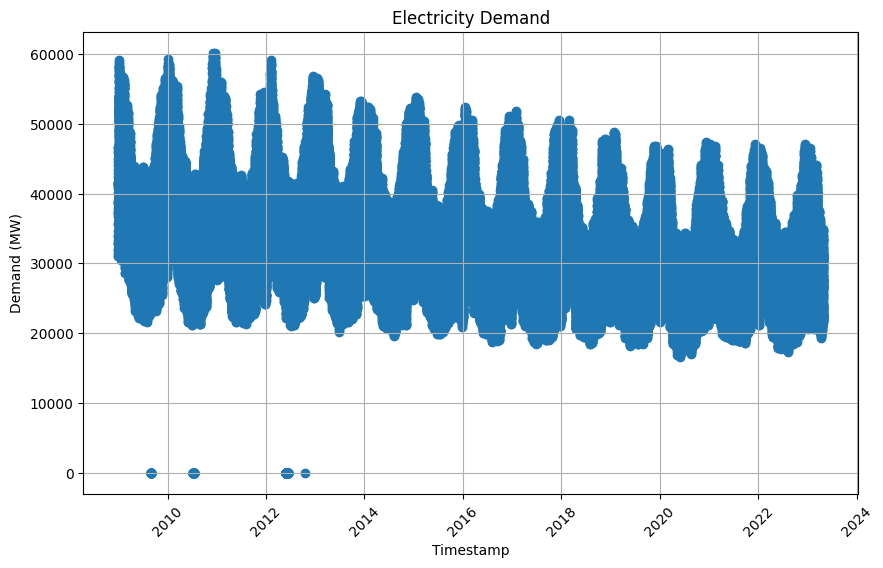

In [6]:
# Plot electricity demand
# interactive_chart(df_energy, start_date=datetime(2009, 1, 1), end_date=datetime(2023, 4, 30))
static_chart(df_energy, start_date=datetime(2009, 1, 1), end_date=datetime(2023, 4, 30))

Seasonal info: The electricity demand chart shows seasonality, so it will be helpfull to consider decompose the time into features that are related to this variable. Thus, some datetime features are extracted related to year, month, day of year, among others. Distribution plots, box plots and violin plots are presented to help with the analysis.

In [7]:
# Create date and time features to analyze seasonality
data_loader.extract_time_features()
df_energy, df_weather, df_datetime = data_loader.load_data('formatted')
display(df_datetime.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250944 entries, 0 to 250943
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   datetime        250944 non-null  datetime64[ns]
 1   date_period     250944 non-null  float64       
 2   date_isholiday  250944 non-null  bool          
 3   date_year       250944 non-null  int64         
 4   date_month      250944 non-null  int64         
 5   date_day        250944 non-null  int64         
 6   date_hour       250944 non-null  int64         
 7   date_minute     250944 non-null  int64         
 8   date_dayofyear  250944 non-null  int64         
 9   date_weekday    250944 non-null  int64         
 10  date_quarter    250944 non-null  int64         
 11  date_week       250944 non-null  int64         
 12  date_isweekend  250944 non-null  bool          
 13  date_daypart    250944 non-null  object        
dtypes: bool(2), datetime64[ns](1), float

None

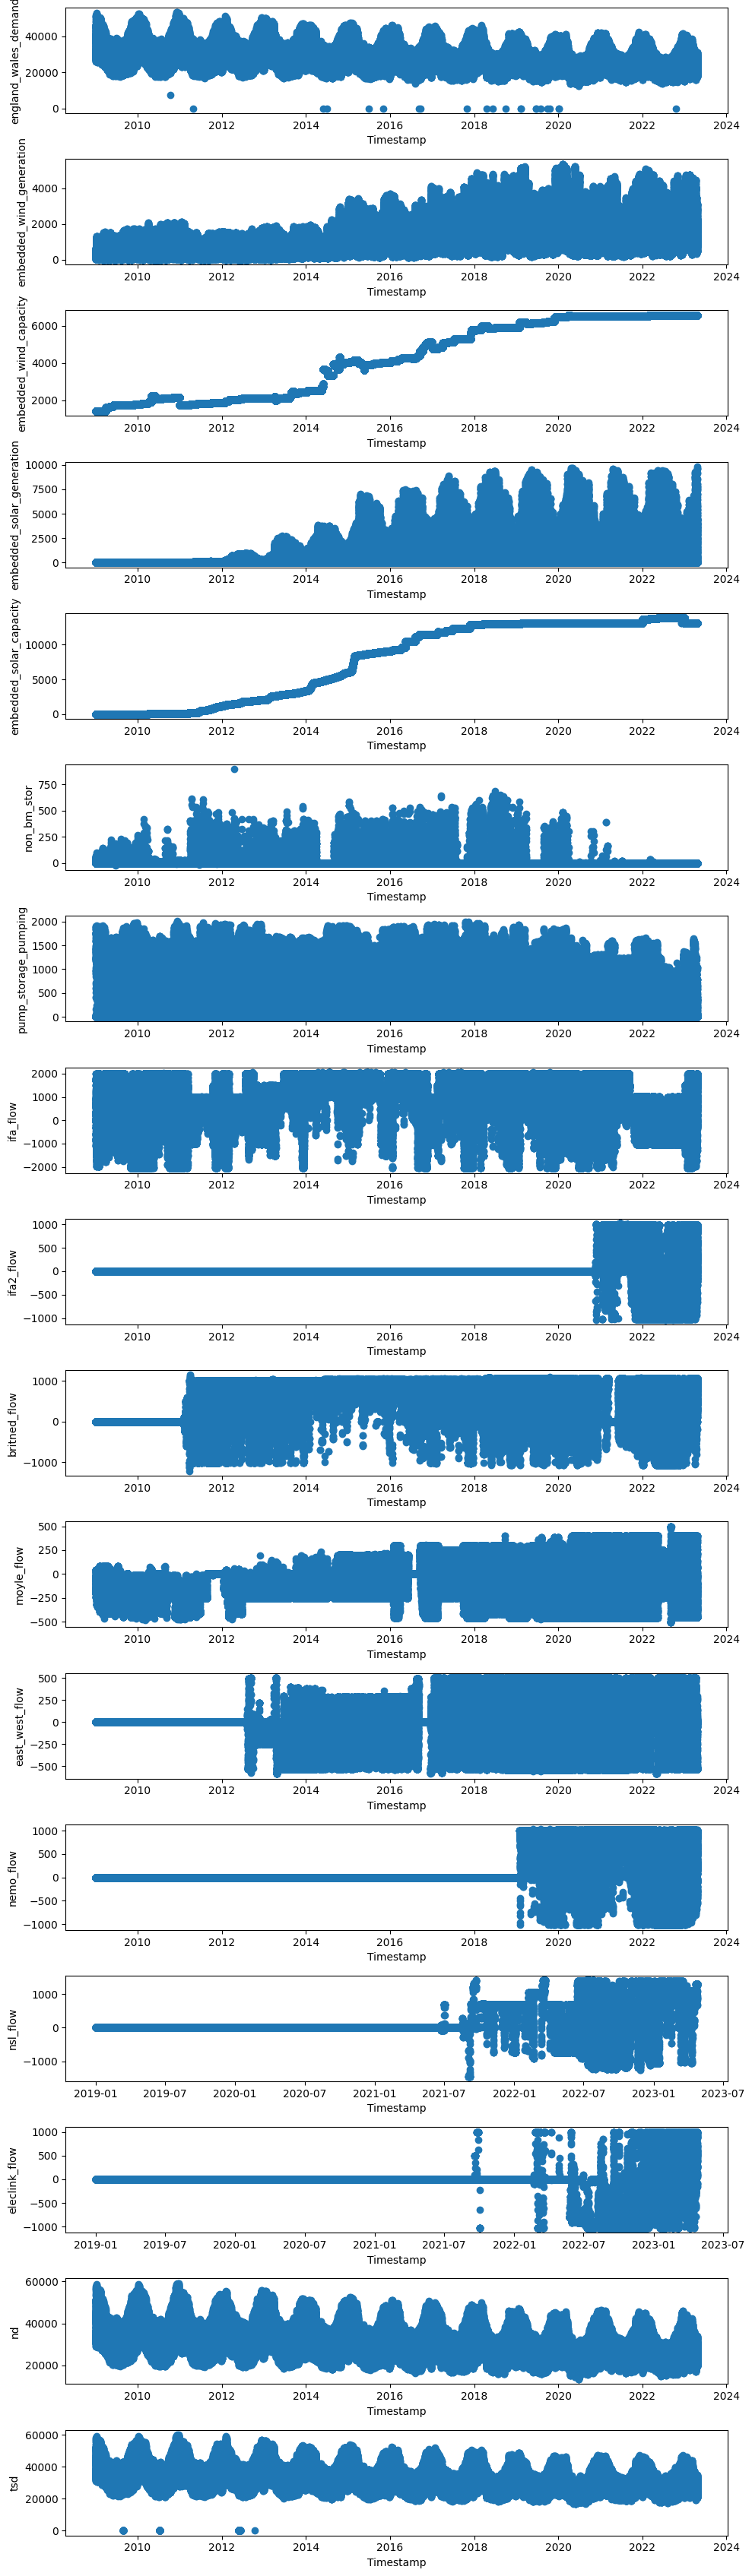

In [8]:
plot_variables(df_energy, df_energy.columns[1:], start_date=datetime(2009, 1, 1), end_date=datetime(2023, 4, 30))

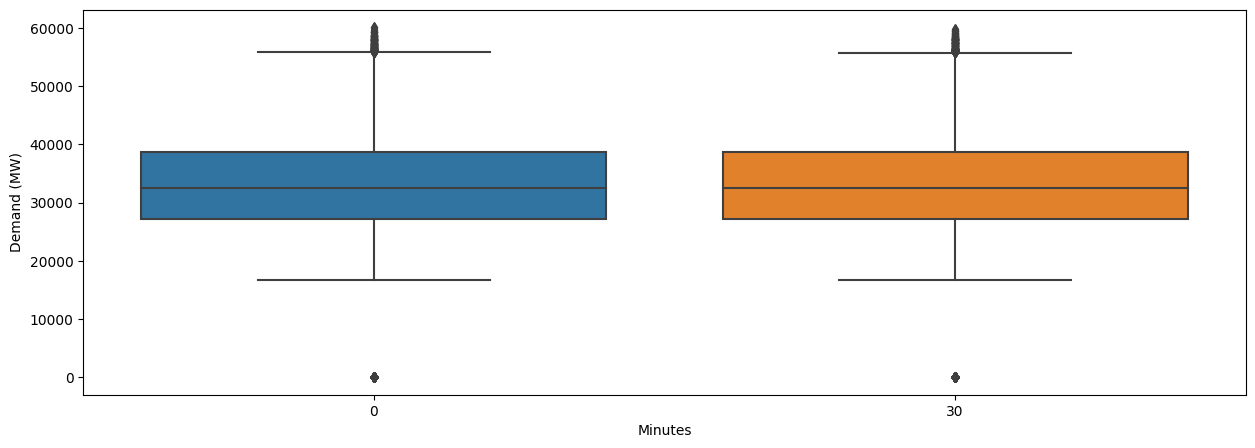

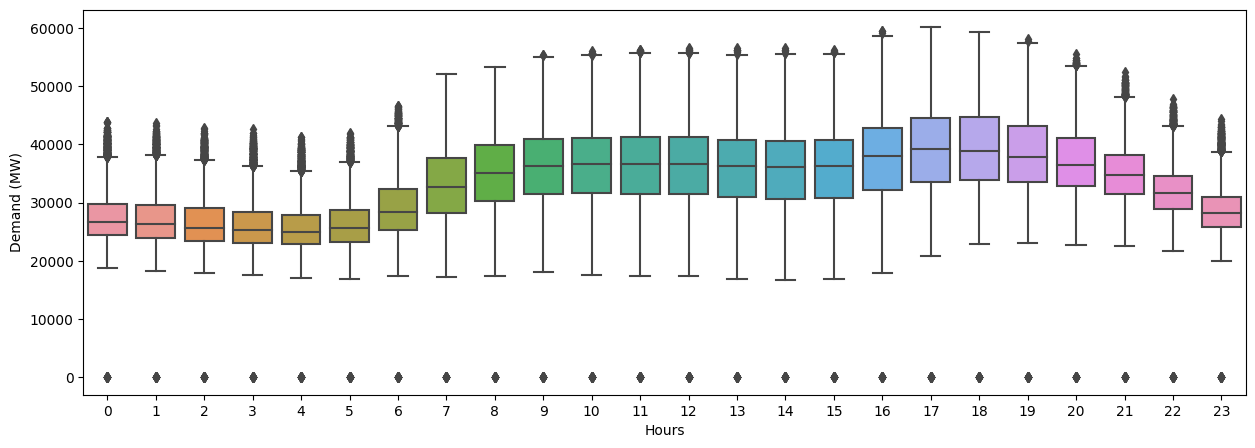

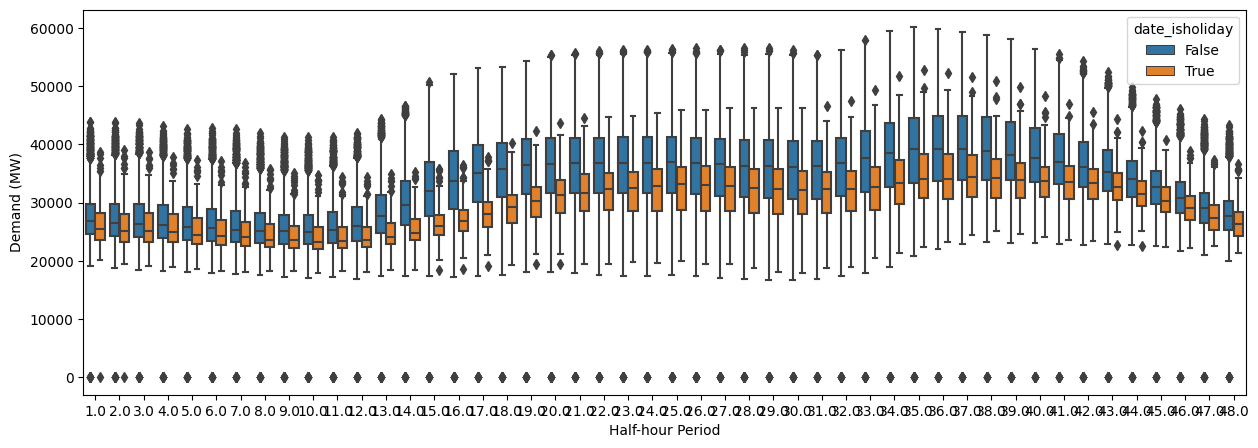

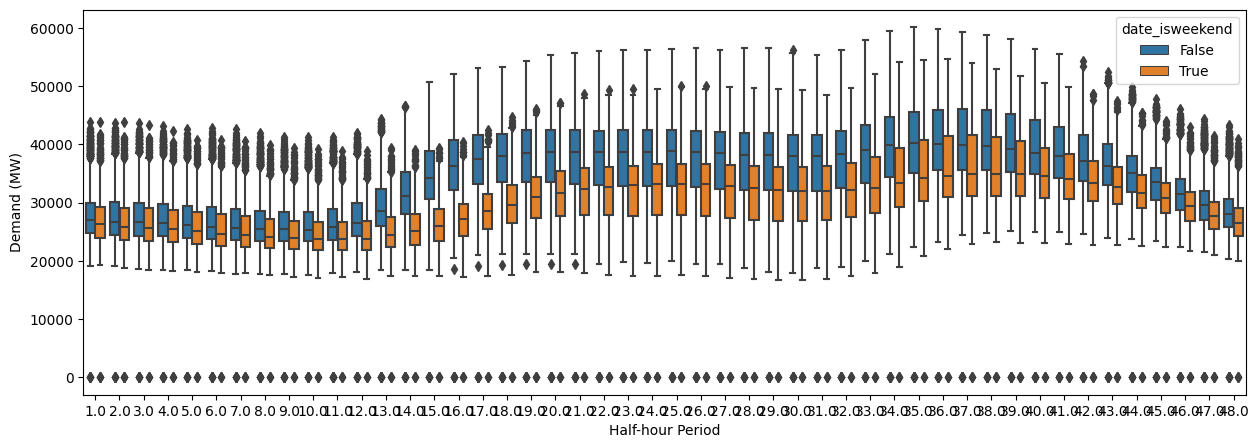

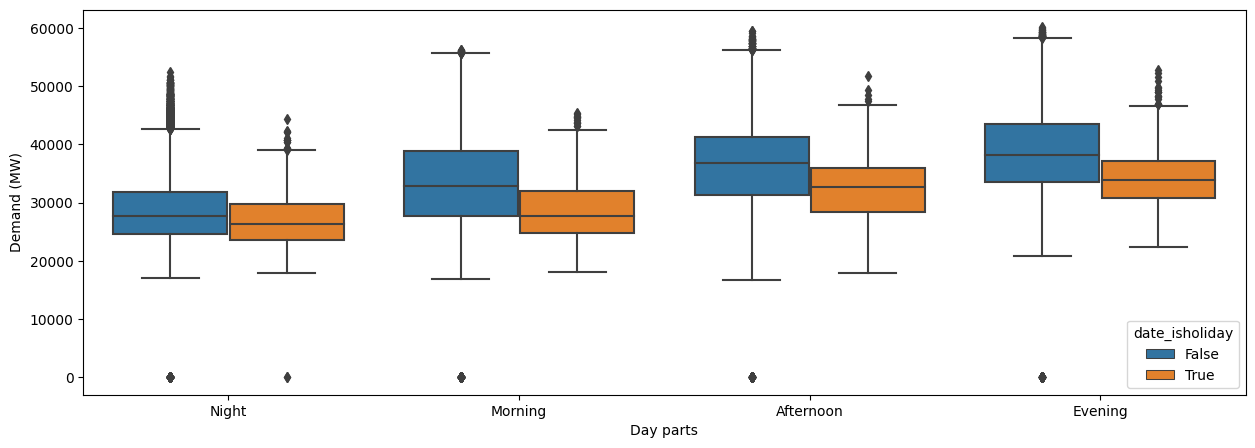

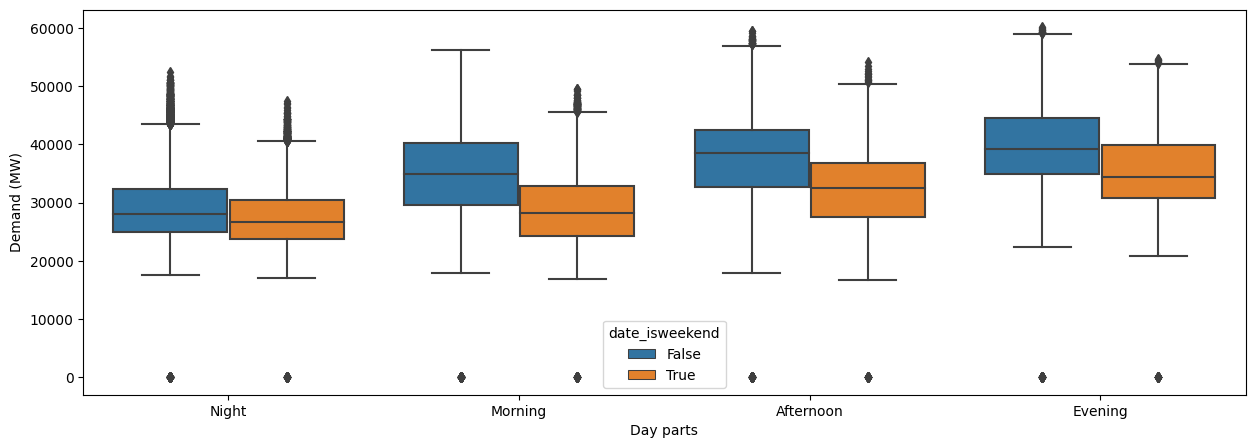

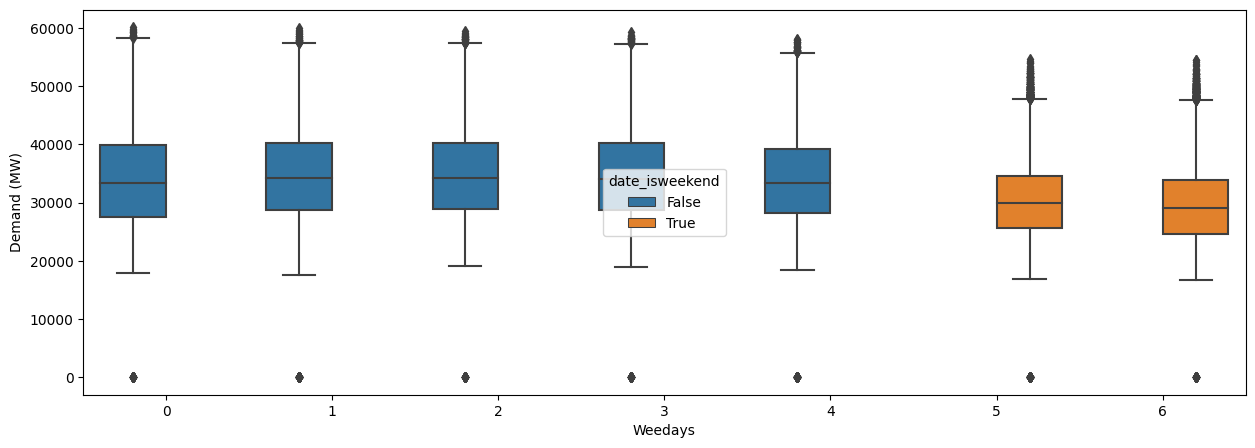

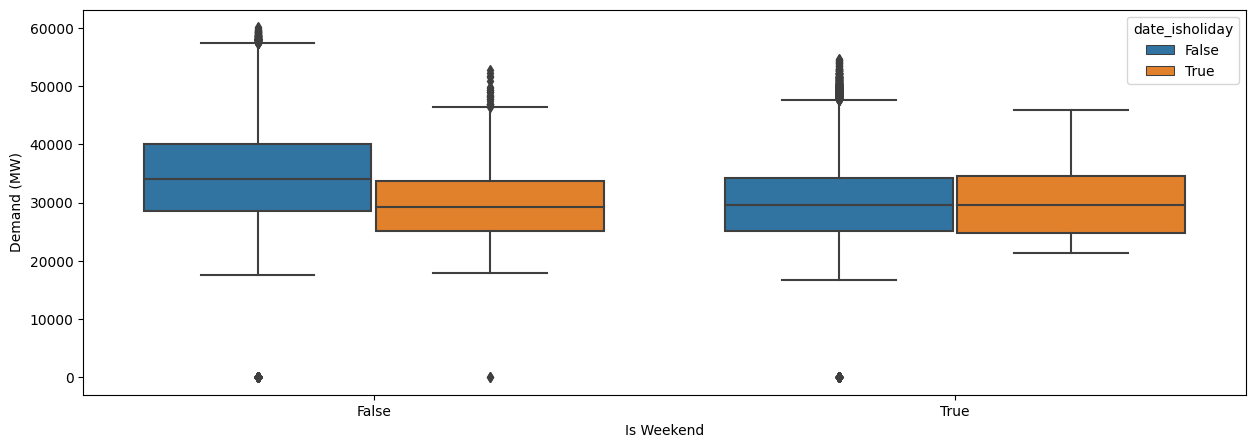

In [9]:
df_energy_time = pd.merge(df_datetime, df_energy[['datetime', 'tsd']], on='datetime', how='left')
plot_seasonal_day_week(df_energy_time)

Hourly and Daily Seasonal analysis

There is a clear pattern of electricity demands that depends on the period during the day. This pattern shows how the demand is higher during the afternoon and the evening, and lower at night and in the morning. The demand is similar during weekdays, and different between weekdays and weekends. The reason for this pattern could be the stop from electricity consumption for enterprises during weekends.

The weekend vs holiday chart indicate that on weekends the electricity demand is similar between holdays and non-holidays. However, on weekdays there is a difference between holdays and non-holidays, and holidays values are similar to weekends. This indicates that perhaps weekends and holidays could have the same effects on electricity demand, so it would be interesting exploring this approach in future analysis. 

The hour and the half-hour period charts show a cyclic pattern. This means that the demand at the beginning is similar to the demand at the end. For example, the demand at 11pm is similar to the demand at midnight. The other features don't show the same pattern.

Also, minutes hold no relevance in the demand. The half hour periods can be seen as a detailed view of the hourly demand.

Let's analyze now the seasonal month and year components.

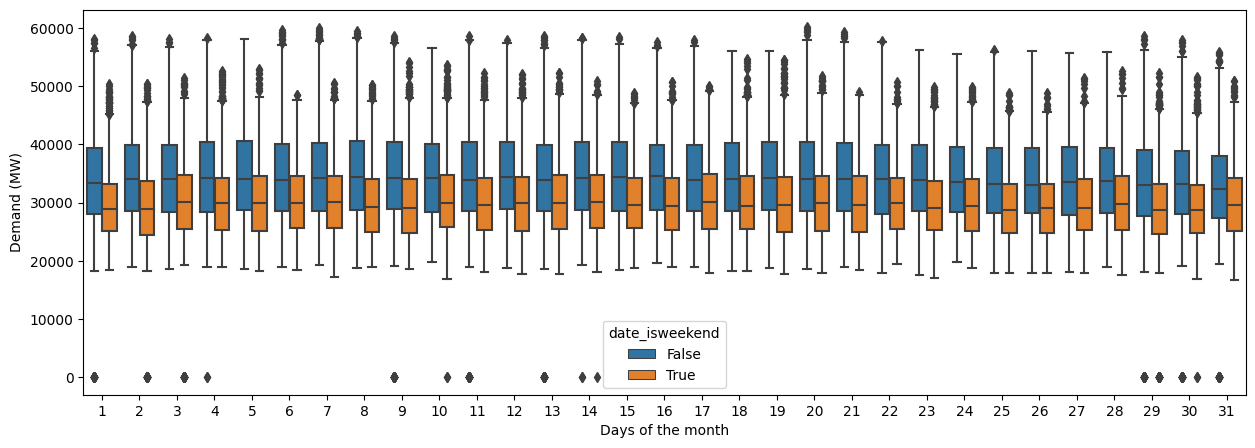

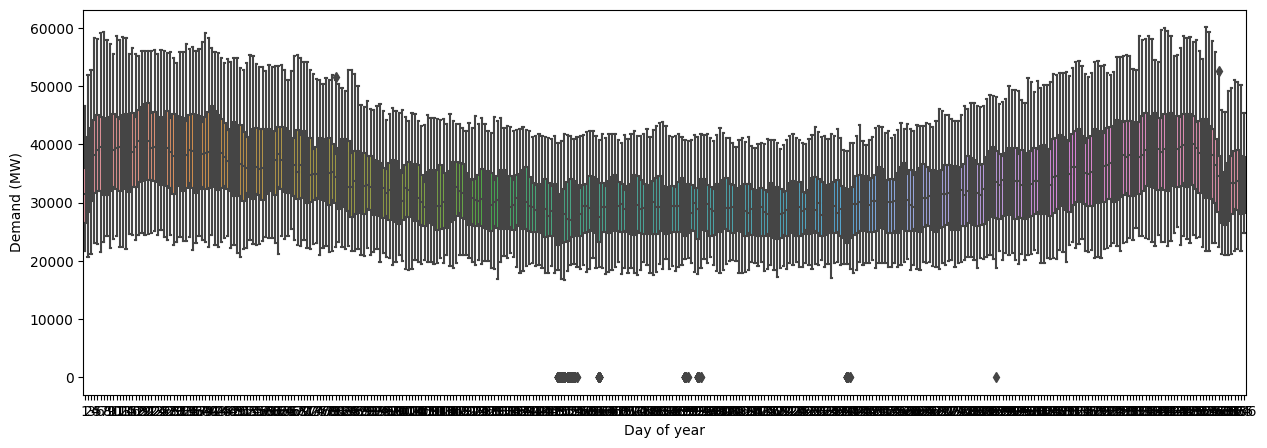

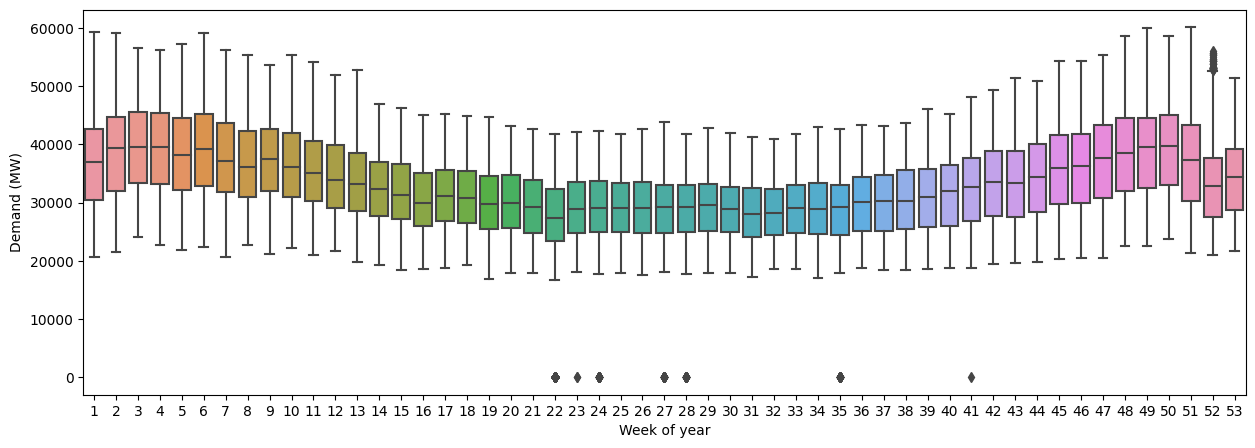

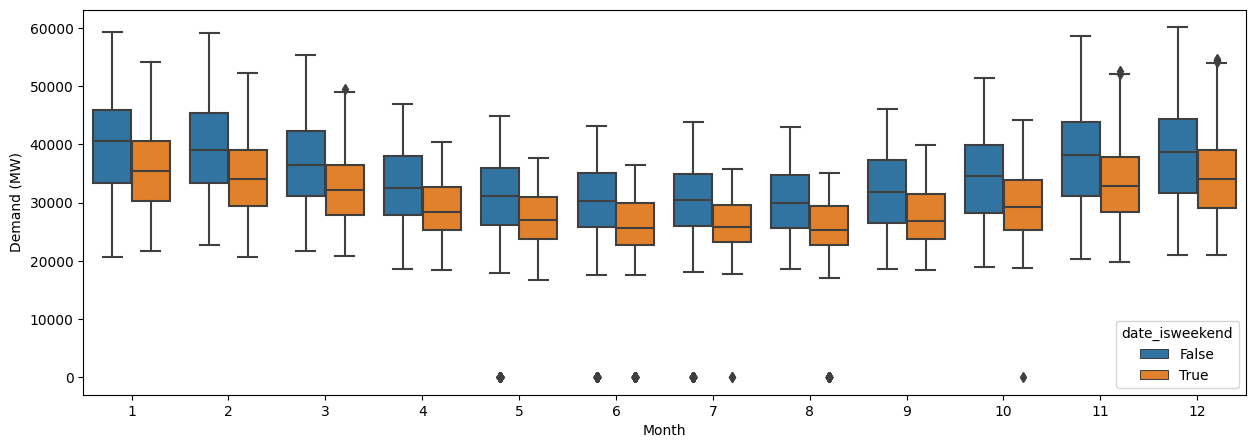

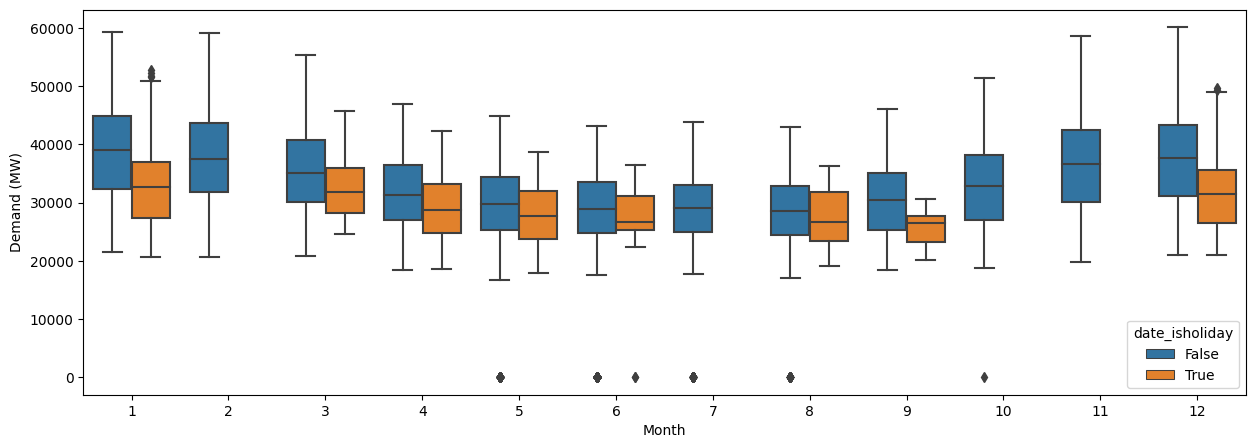

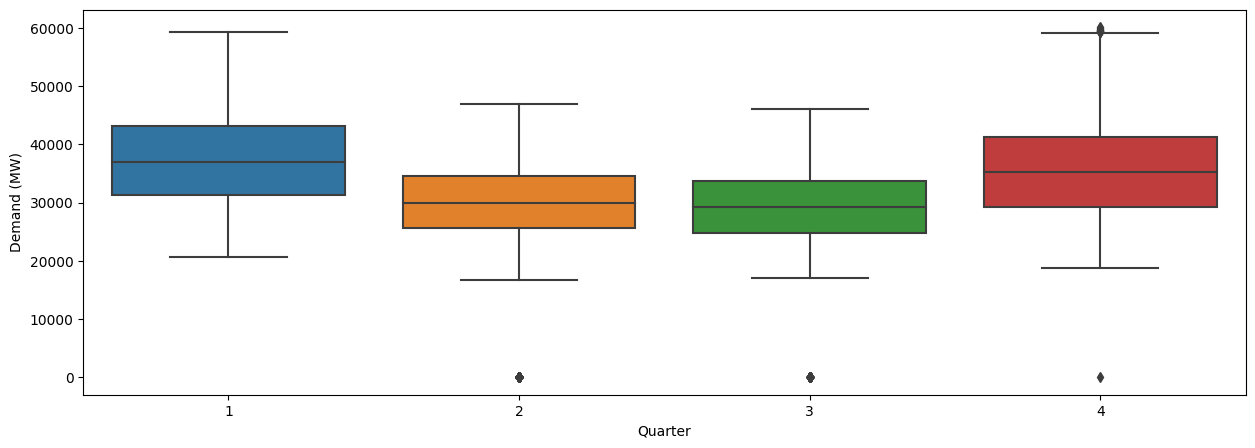

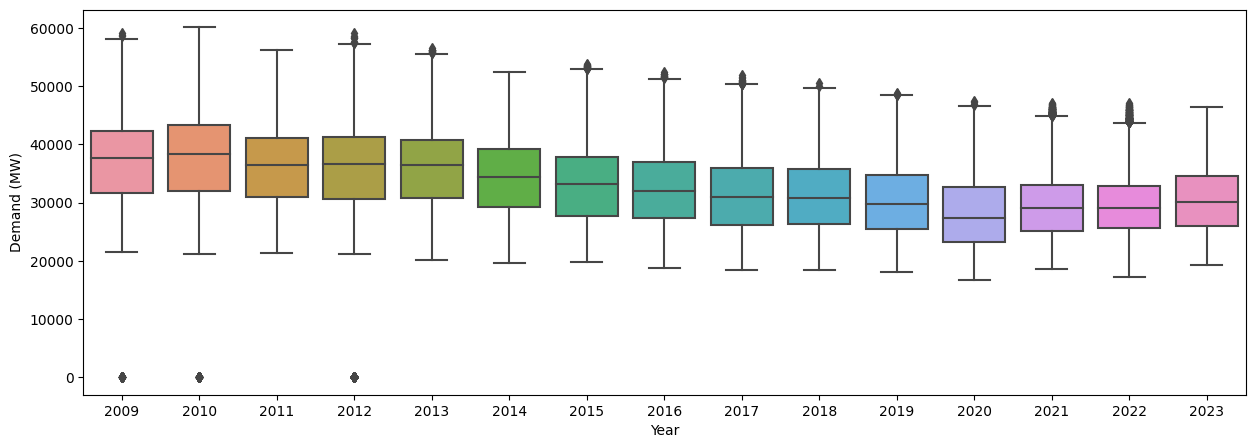

In [10]:
plot_seasonal_month_year(df_energy_time)

Monthly and Yearly Seasonal analysis

The day of the month chart indicates that this feature do not have an effect on the electricity demand. Meaning that could be excluded from the forecast model.

The day of year, week, month and quarter shows a lower demand during summer and higher during winter. This is because of the energy used during winter to heat buildings. Temperature in winters in the UK can go under 20 Fahrenheit degrees (-6.67 Celsius degree). These features also show a cyclic pattern. This means that the demand at the beginning is similar to the demand at the end. For example, January demand is similar to the December demand. Another interesting fact, is that, in the presented orden, this features show the same pattern in the demand from a more to a less detailed demand pattern.

The year components shows a decreasing pattern of the demand, which is consistent with the electricity reduction of the UK stated in the news.

Partial conclusions: All time features in and above hour level have some kind of effect on the demand. This is consistent to the time-series approach taken to solve this problem. Therefore, they should be considered to create the forecast model.

The next step is to handle missing values and outliers. Thus, the distribution of the demand is plotted.

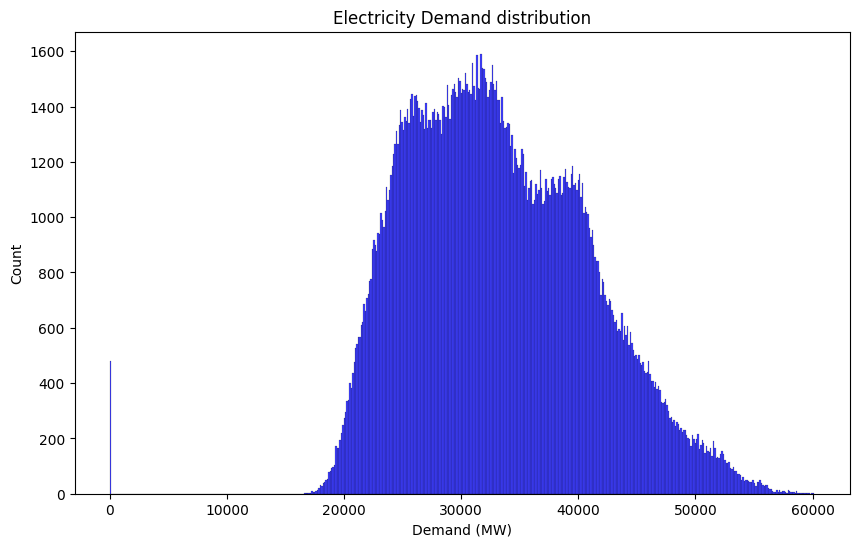

In [11]:
# Plot electricity demand distribution
distribution_plot(df_energy)

In [13]:
# Detect missing data
datetime_nan = df_energy.loc[df_energy['tsd'].isna(), 'datetime']
print('Timestamps with nan values:')
display(datetime_nan)
datetime_zero = df_energy.loc[df_energy['tsd'] == 0, 'datetime']
print('Timestamps with zero values:')
display(datetime_zero)

Timestamps with nan values:


4222     2009-03-29 23:00:00
4223     2009-03-29 23:30:00
21694    2010-03-28 23:00:00
21695    2010-03-28 23:30:00
39166    2011-03-27 23:00:00
39167    2011-03-27 23:30:00
56638    2012-03-25 23:00:00
56639    2012-03-25 23:30:00
74446    2013-03-31 23:00:00
74447    2013-03-31 23:30:00
91918    2014-03-30 23:00:00
91919    2014-03-30 23:30:00
109390   2015-03-29 23:00:00
109391   2015-03-29 23:30:00
126862   2016-03-27 23:00:00
126863   2016-03-27 23:30:00
144334   2017-03-26 23:00:00
144335   2017-03-26 23:30:00
161806   2018-03-25 23:00:00
161807   2018-03-25 23:30:00
179614   2019-03-31 23:00:00
179615   2019-03-31 23:30:00
197086   2020-03-29 23:00:00
197087   2020-03-29 23:30:00
214558   2021-03-28 23:00:00
214559   2021-03-28 23:30:00
232030   2022-03-27 23:00:00
232031   2022-03-27 23:30:00
249502   2023-03-26 23:00:00
249503   2023-03-26 23:30:00
Name: datetime, dtype: datetime64[ns]

Timestamps with zero values:


11522   2009-08-29 01:00:00
11523   2009-08-29 01:30:00
11524   2009-08-29 02:00:00
11525   2009-08-29 02:30:00
11526   2009-08-29 03:00:00
                ...        
60380   2012-06-11 22:00:00
60381   2012-06-11 22:30:00
60382   2012-06-11 23:00:00
60383   2012-06-11 23:30:00
66337   2012-10-14 00:30:00
Name: datetime, Length: 479, dtype: datetime64[ns]

Missing data and outliers: There are some missing measurement from the two last periods of one of the last days of March every year. It seems that there is some pattern in the missing data, that could be related to the data acquisition system. It is possible to replace this data based on the distribution of the demand in each period. Also, measurements equals to zero are considered missing (or outliers) and seem to belong to entire days. The zero measurement can also be replace.
However, the first approach is to remove observations with missing values of the electricity demand. In further analysis, removing the days that have some periods with missing values can be an approach, or imputation strategies can be applied to fill the missing values.

In [14]:
# Handling missing data
data_loader.handle_missing_data('remove_time')
df_energy, df_weather, df_datetime = data_loader.load_data('no_missing')

Weather data: Analize weather patterns and relation with the electricity demand

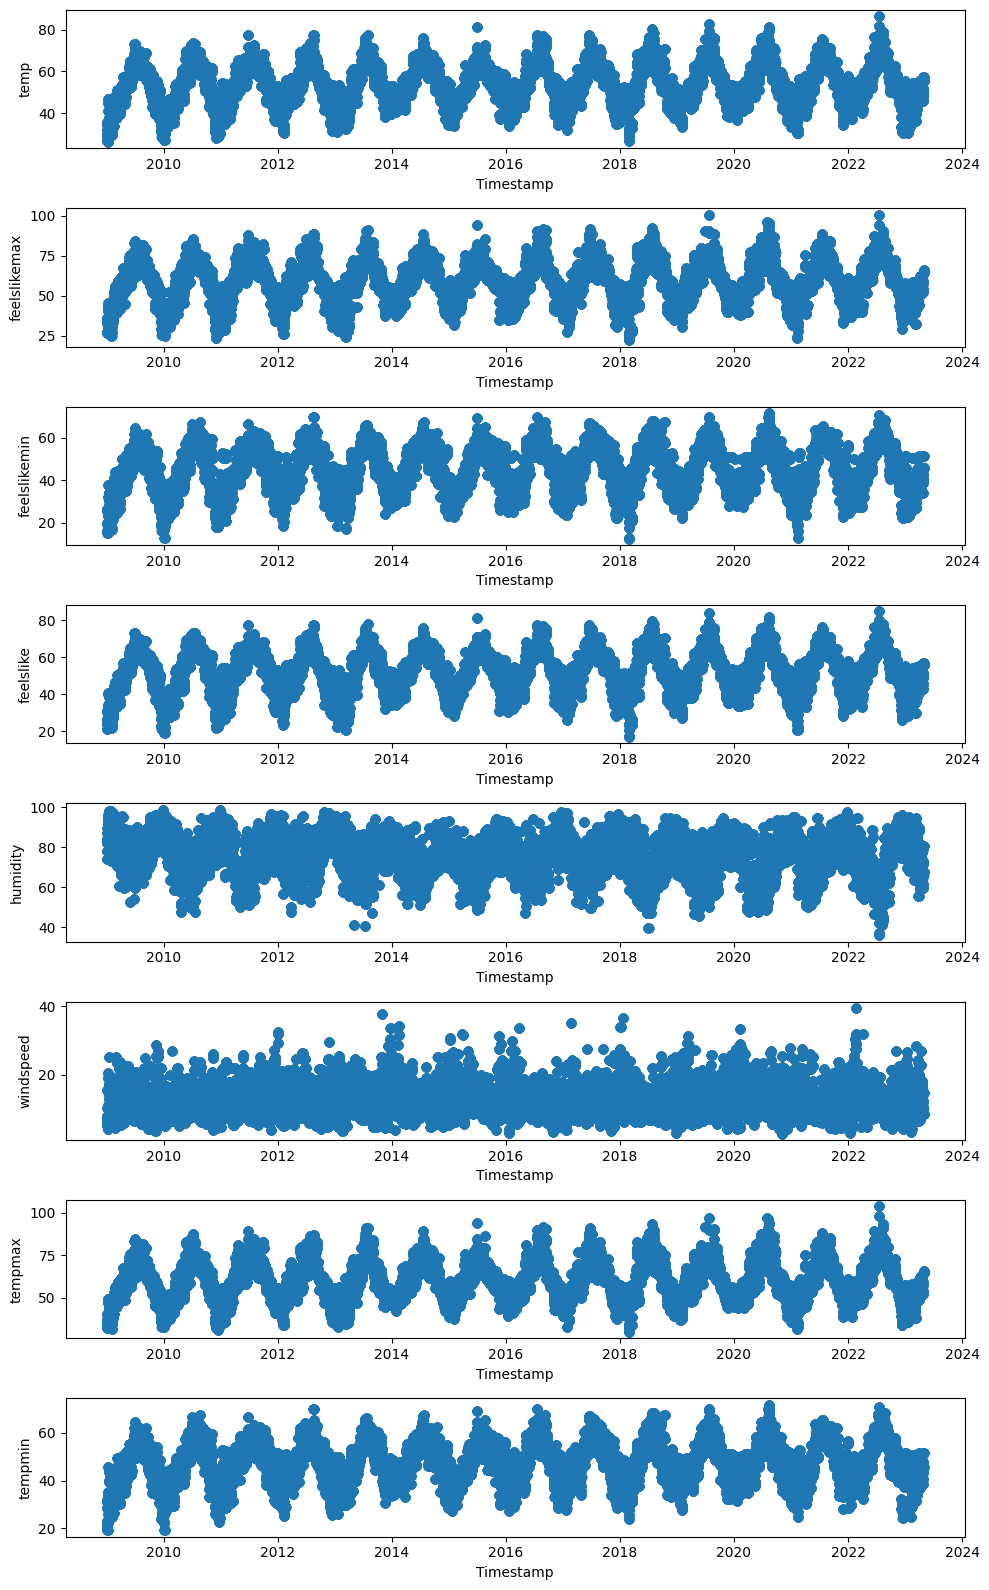

In [15]:
plot_variables(df_weather, df_weather.columns[1:], start_date=datetime(2009, 1, 1), end_date=datetime(2023, 4, 30))

It appears that weather data also has seasonal components.

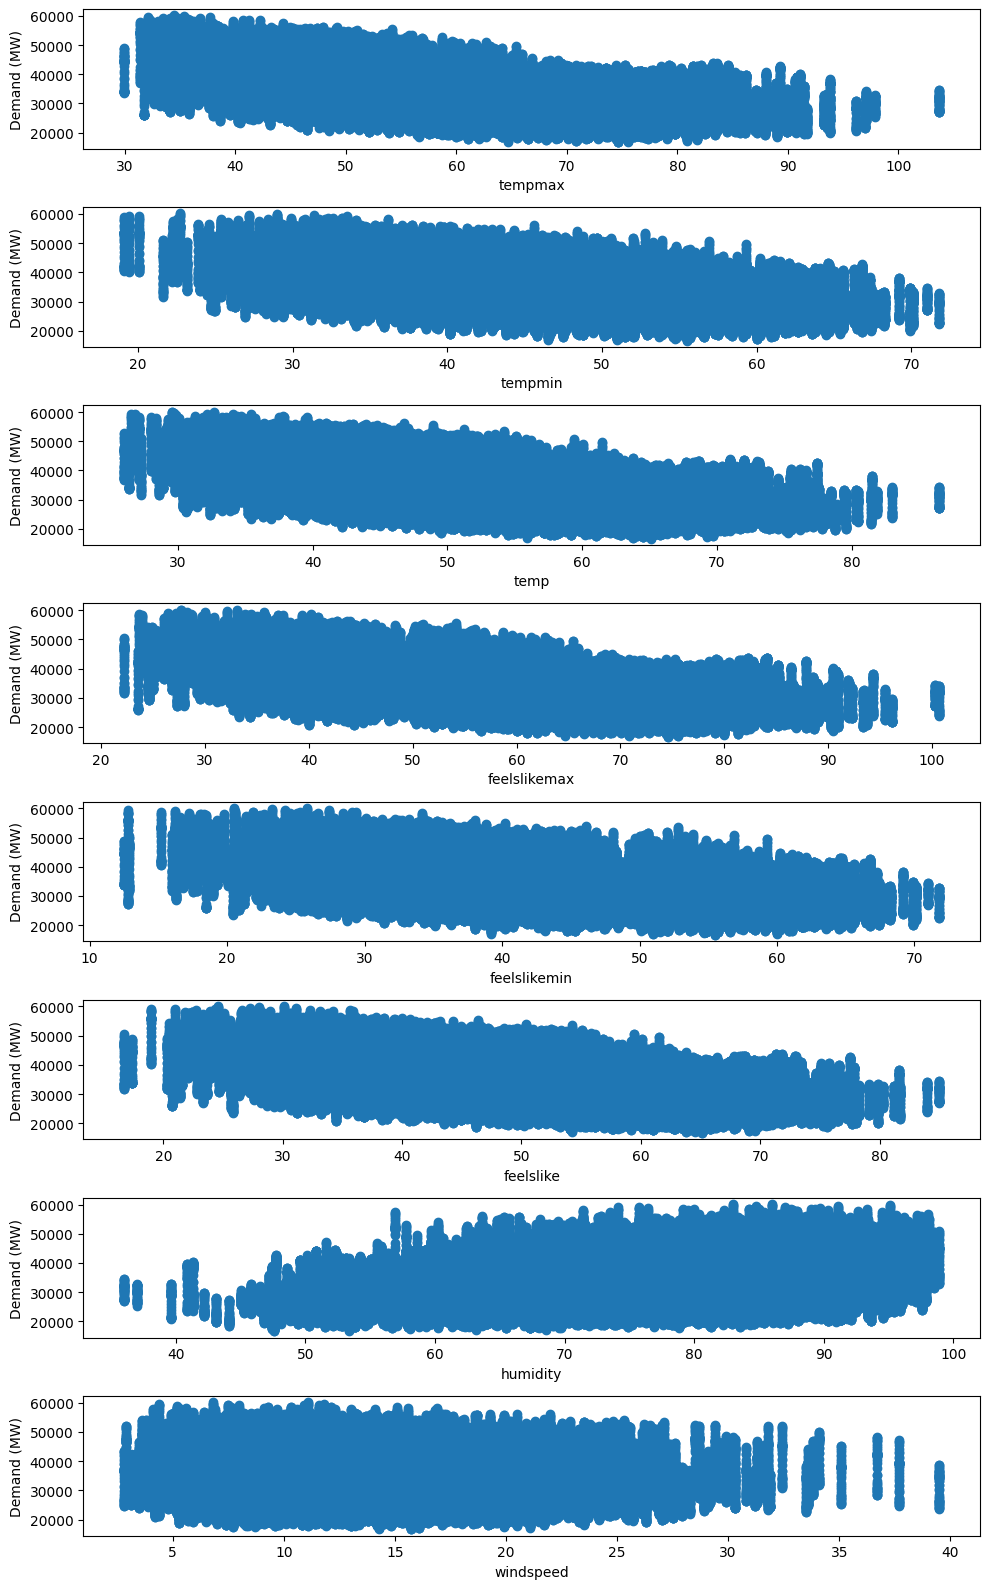

In [16]:
df_energy_weather = pd.merge(df_energy[['datetime', 'tsd']], df_weather, on='datetime', how='left')
plot_weather_demand(df_energy_weather, df_weather.columns[1:])

As asume at the beginnig, weather data is related with electricity demand. It seems that the temperature is the variable with more influence over the demand. Thus, all weather features should be included in the forecast model.

## Data transformation

## Model creation

## Forecast visualization